In [1]:
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score, f1_score, auc,roc_auc_score,cohen_kappa_score,matthews_corrcoef
#smotk=SMOTETomek(random_state=139)
resample2=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_frame = pd.read_csv('/content/drive/MyDrive/parkinsons.data')

Mounted at /content/drive


In [3]:
num_0 = (data_frame["status"] == 0).sum()
num_1 = (data_frame["status"] == 1).sum()

print("number of rows with class0:",num_0)
print("number of rows with class1:",num_1)

number of rows with class0: 48
number of rows with class1: 147


In [4]:
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import numpy as np

# Assuming 'data_frame' is your DataFrame containing the data

# Step 1: Balancing using SMOTE+TOMEK
resample2 = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x = data_frame.drop(["status", "name"], axis=1)
y = data_frame["status"]
x_res2, y_res2 = resample2.fit_resample(x, y)

# Step 2: Augmentation
data = np.column_stack((x_res2, y_res2))

x_balanced = data[:, :-1]
y_balanced = data[:, -1]

num_samples_to_add = 600

additional_samples_indices = np.concatenate([
    np.random.choice(np.where(y_balanced == 0)[0], num_samples_to_add // 2, replace=True),
    np.random.choice(np.where(y_balanced == 1)[0], num_samples_to_add // 2, replace=True)
])

x_augmented = np.vstack([x_balanced, x_balanced[additional_samples_indices]])
y_augmented = np.hstack([y_balanced, y_balanced[additional_samples_indices]])

print("Number of samples after augmentation:")
print("Class 0:", np.sum(y_augmented == 0))
print("Class 1:", np.sum(y_augmented == 1))

Number of samples after augmentation:
Class 0: 447
Class 1: 447


In [5]:
from sklearn.decomposition import PCA

# Instantiate PCA with the desired number of components
#pca = PCA(n_components=18)

# Fit PCA on your data and transform it
#X_pca = pca.fit_transform(x_augmented)

#---------------------------


from sklearn.decomposition import PCA

# Initialize PCA with desired number of components
pca = PCA(n_components=10)  # Adjust the number of components as needed

# Fit PCA on the balanced and augmented dataset
pca.fit(x_augmented)

# Transform the dataset to the lower-dimensional space
x_pca = pca.transform(x_augmented)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Select the number of components that explain a certain amount of variance (e.g., 95%)
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1

# Re-initialize PCA with the selected number of components
pca = PCA(n_components=n_components)

# Fit PCA on the balanced and augmented dataset
pca.fit(x_augmented)

# Transform the dataset to the lower-dimensional space using the selected number of components
x_pca = pca.transform(x_augmented)


In [6]:
selected_features = x_pca[:, :18]
print(selected_features.shape)

(894, 3)


# PCA + Bagging

Accuracy: 0.9273743016759777
Precision: 0.9487179487179487
Recall: 0.891566265060241
F1-score: 0.9192546583850931
Confusion Matrix:


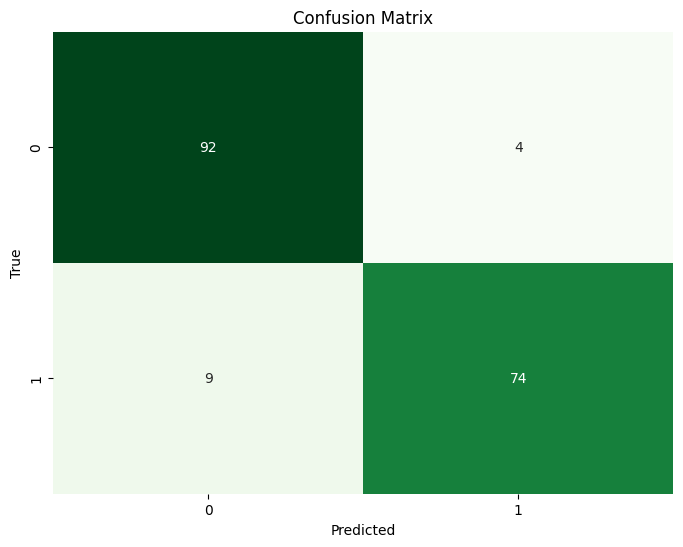

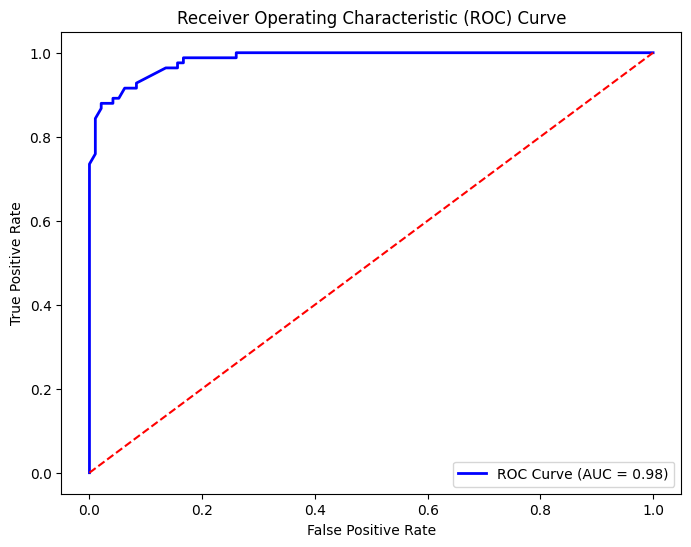

Accuracy: 0.9274 Precision: 0.9487 Recall: 0.8916 F1 Score: 0.9193 AUC Score: 0.9249 MCC: 0.8547 Kappa: 0.8534
Specificity: 0.9583


In [7]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt



# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(selected_features, y_augmented, test_size=0.2, random_state=42)

# Define the base classifier
base_classifier = DecisionTreeClassifier(max_depth=5)  # You can use any classifier here

# Create a Bagging Classifier
bagging_clf = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

# Train the Bagging Classifier
bagging_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = bagging_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# PCA + Boosting

Accuracy: 0.8715083798882681
Confusion Matrix:
[[86 10]
 [13 70]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88        96
         1.0       0.88      0.84      0.86        83

    accuracy                           0.87       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.87      0.87      0.87       179

Accuracy: 0.8715083798882681
Precision: 0.875
Recall: 0.8433734939759037
F1-score: 0.8588957055214724
Confusion Matrix:


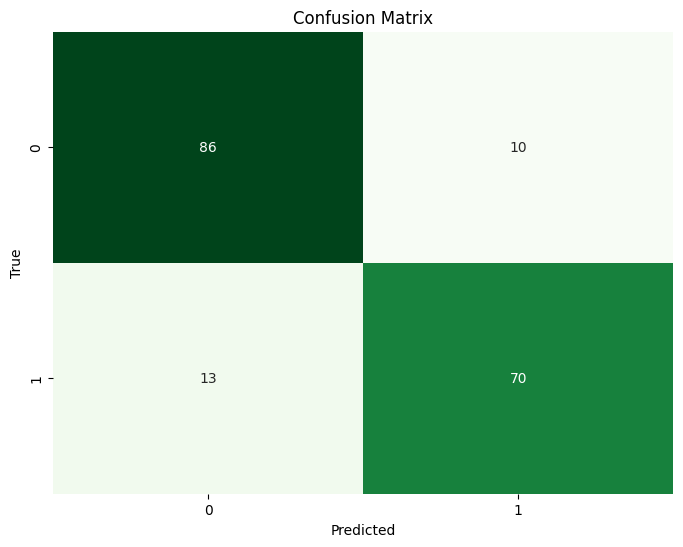

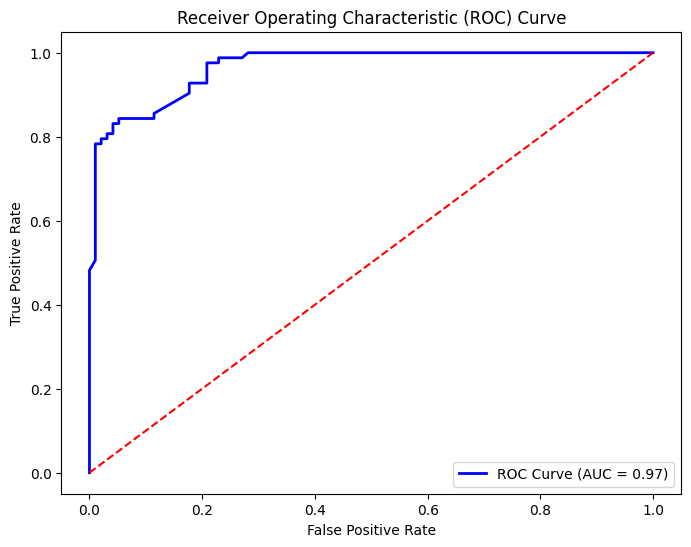

Accuracy: 0.8715 Precision: 0.8750 Recall: 0.8434 F1 Score: 0.8589 AUC Score: 0.8696 MCC: 0.7414 Kappa: 0.7410
Specificity: 0.8958


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(selected_features, y_augmented, test_size=0.2, random_state=42)


# Create a base Decision Tree classifier (a weak learner)
base_classifier = DecisionTreeClassifier(max_depth=1)  # You can adjust the hyperparameters

# Create an AdaBoost classifier using the base classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the classifier on the training data
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = adaboost_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# PCA + Stacking

Accuracy: 0.994413407821229
Confusion Matrix:
[[95  1]
 [ 0 83]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        96
         1.0       0.99      1.00      0.99        83

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179

Accuracy: 0.994413407821229
Precision: 0.9880952380952381
Recall: 1.0
F1-score: 0.9940119760479043
Confusion Matrix:


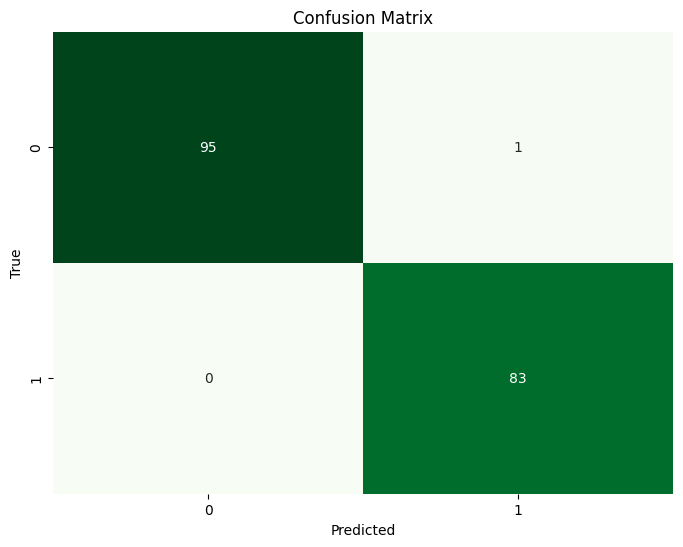

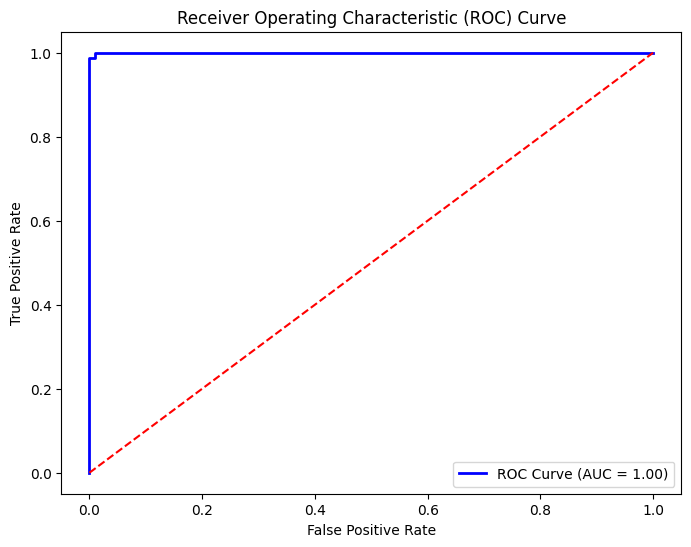

Accuracy: 0.9944 Precision: 0.9881 Recall: 1.0000 F1 Score: 0.9940 AUC Score: 0.9948 MCC: 0.9888 Kappa: 0.9888
Specificity: 0.9896


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(selected_features, y_augmented, test_size=0.2, random_state=42)

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the stacking classifier on the training data
stacking_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = stacking_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# PCA + Voting

Accuracy on the test set with selected features: 0.888268156424581
Accuracy: 0.888268156424581
Precision: 0.8247422680412371
Recall: 0.963855421686747
F1-score: 0.8888888888888888
Confusion Matrix:


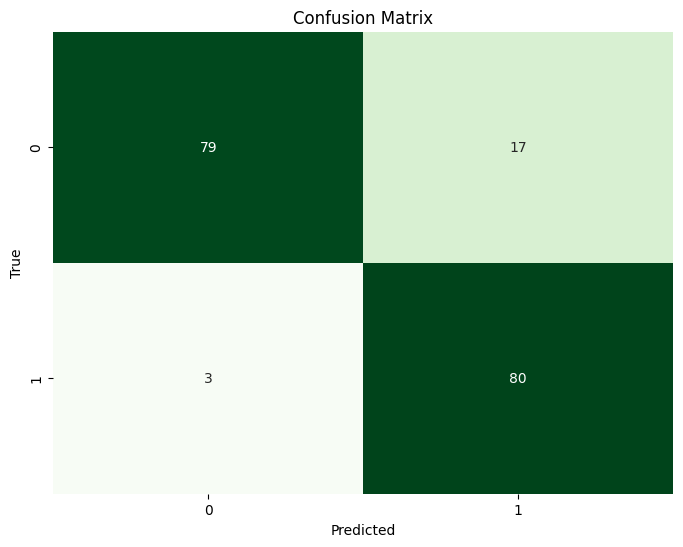

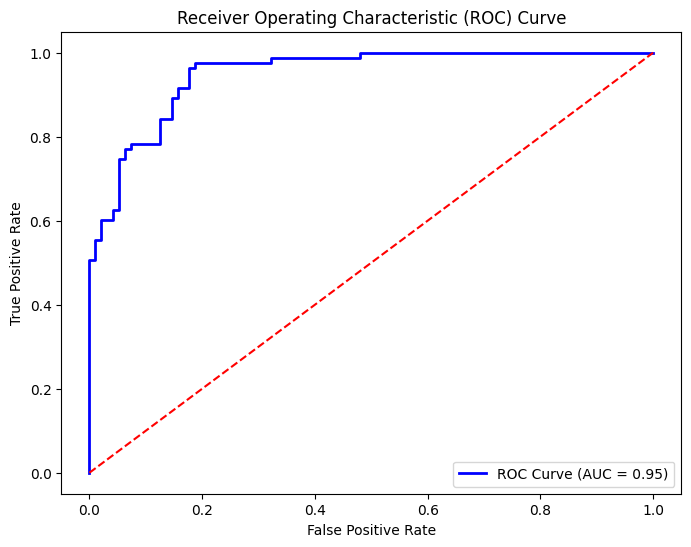

Accuracy: 0.8883 Precision: 0.8247 Recall: 0.9639 F1 Score: 0.8889 AUC Score: 0.8934 MCC: 0.7875 Kappa: 0.7779
Specificity: 0.8229


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(selected_features, y_augmented, test_size=0.2, random_state=42)

# Define the base classifiers
log_reg_clf = LogisticRegression()
decision_tree_clf = DecisionTreeClassifier(max_depth=5)
svm_clf = SVC(kernel='linear', probability=True)

# Create a Voting Classifier using the base classifiers
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', decision_tree_clf), ('svm', svm_clf)],
    voting='soft'  # Use 'soft' voting to get class probabilities
)

# Train the Voting Classifier on the training data with selected features
voting_clf.fit(X_train, y_train)

# Make predictions on the test set with selected features
y_pred = voting_clf.predict(X_test)

# Evaluate the performance of the classifier with selected features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set with selected features: {accuracy}")

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

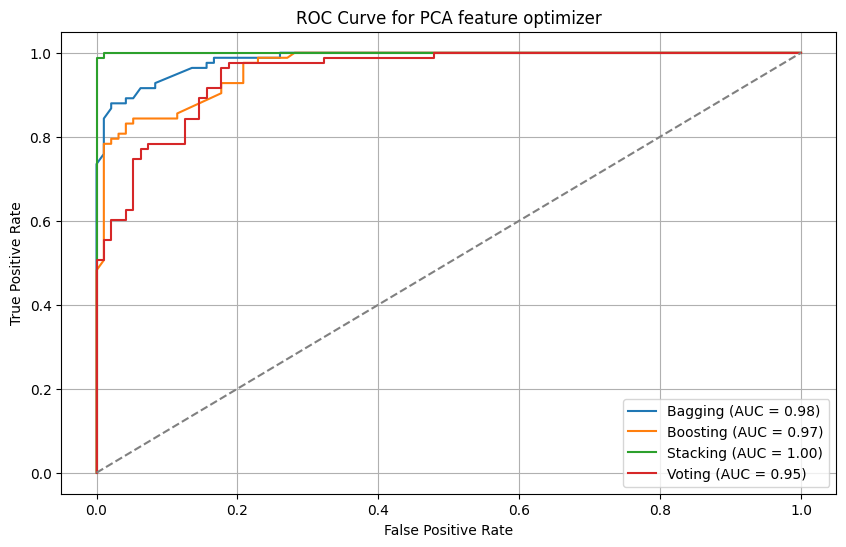

In [12]:
from sklearn.metrics import roc_curve, auc
# Initialize classifiers
classifiers = {
    "Bagging": bagging_clf,
    "Boosting": adaboost_classifier,
    "Stacking": stacking_classifier,
    "Voting": voting_clf
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PCA feature optimizer')
plt.legend()
plt.grid(True)
plt.show()